## Figure 2: Performance of the full perturbative error mitigation 

We will show the performance of the _general_ truncation scheme to recover the full bitstring distribution, as a function of cutoff weight $w$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

import utils
import response_matrix

In [2]:
# Utilities for making probability distributions

def make_uniform(n):
    """Make the uniform distribution over n qubits."""
    d = 1 << n
    return np.ones(d) / d

def make_random(n):
    d = 1 << n
    out = np.random.rand(d)
    return out / out.sum()


### Compute the corrected prob distribution using Algorithm 1

### Construct test R

We enforce that $R$ has a tensor structure so that multi-flip events are necessarily exponentially suppressed in weight change of bitstring.

In [3]:
# Arrays of q(0|1) and q(1|0)
q01_arr = [0.09, .07, 0.12, 0.08, 0.11]
q10_arr = [0.04, .03, .05, 0.04, 0.02]
R = response_matrix.Rmatrix(q01_arr, q10_arr)
Rinv = np.linalg.inv(R)

Text(0.5, 1.0, 'Initial comparison')

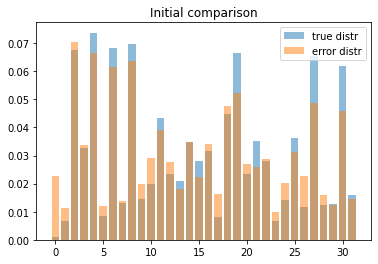

In [4]:
n = len(q01_arr)
x = np.arange(1 << n)
p_true = make_random(n)
p_prime = R @ p_true

plt.bar(x, p_true, alpha=0.5, label="true distr")
plt.bar(x, p_prime, alpha=0.5, label="error distr")
plt.legend()
plt.title("Initial comparison")

### Parameters for R matrix

In [9]:
np.random.randn(1)

array([-1.44385442])

In [14]:
def generate_R(qmax, n):
    """qmax is the 'characteristic rate' that should be the maximum over individual flip rates"""
    q01_arr = np.random.random(n) * qmax
    q10_arr = np.random.random(n) * qmax
    return response_matrix.Rmatrix(q01_arr, q10_arr)
    
# q01_arr = np.asarray([0.09, .07, 0.12, 0.08, 0.11, 0.06, 0.07, 0.11, 0.05, 0.08]) / 1.7
# q10_arr = np.asarray([0.04, .03, .05, 0.04, 0.03, .05, .04, 0.06, 0.05, 0.03]) / 1.7



## Two experiments

1. First experiment: Fix $q$, then plot $d(p, \tilde{p})$ as a function of $w$ for changing no. qubits
2. Second exeriment: Fix $n$, then plot $d(p, \tilde{p})$ as a function of $q$ for changing w cutoff


In [23]:
def trace_dist(a, b):
    # use trace distance for comparing full distributions
    return abs(a - b).sum()

# First experiment
wvals = [1, 2, 3, 4]
nqubits_lst = [4, 6, 8, 10]
qfixed = .06

# Baseline contains the uncorrected distribution comparison to ptrue
baseline = np.zeros(len(nqubits_lst))
# Outcomes contain truncated result comparisons
outcomes = np.zeros((len(wvals), len(nqubits_lst))) # rows correspond to w=1,2...

for j, n_qubits in enumerate(nqubits_lst):
    # Generate response matrix and artificial readout error
    R = generate_R(qfixed, n_qubits)
    Rinv = np.linalg.inv(R)
    p_true = make_random(n_qubits)
    p_prime = R @ p_true
    
    # Full distribution correction
    baseline[j] = trace_dist(p_prime, p_true)
    for k, w in enumerate(wvals):
        p_fixed = response_matrix.invert_pfull_truncated(R, p_prime, w1=w, w2=w)
        outcomes[k,j] = trace_dist(p_fixed, p_true)
        

In [28]:
# Second experiment
# qvals = [0.01, 0.03, 0.05, 0.07, 0.09]
qvals = [0.01, 0.03, 0.05]
n_qubits = 6

# Baseline contains the uncorrected distribution comparison to ptrue
q_baseline = np.zeros(len(qvals))
# Outcomes contain truncated result comparisons
q_outcomes = np.zeros((len(wvals), len(qvals))) # rows correspond to w=1,2...

for j, qmax in enumerate(qvals):
    # Generate response matrix and artificial readout error
    R = generate_R(qmax, n_qubits)
    Rinv = np.linalg.inv(R)
    p_true = make_random(n_qubits)
    p_prime = R @ p_true
    
    # Full distribution correction
    q_baseline[j] = trace_dist(p_prime, p_true)
    for k, w in enumerate(wvals):
        p_fixed = response_matrix.invert_pfull_truncated(R, p_prime, w1=w, w2=w)
        q_outcomes[k,j] = trace_dist(p_fixed, p_true)
        

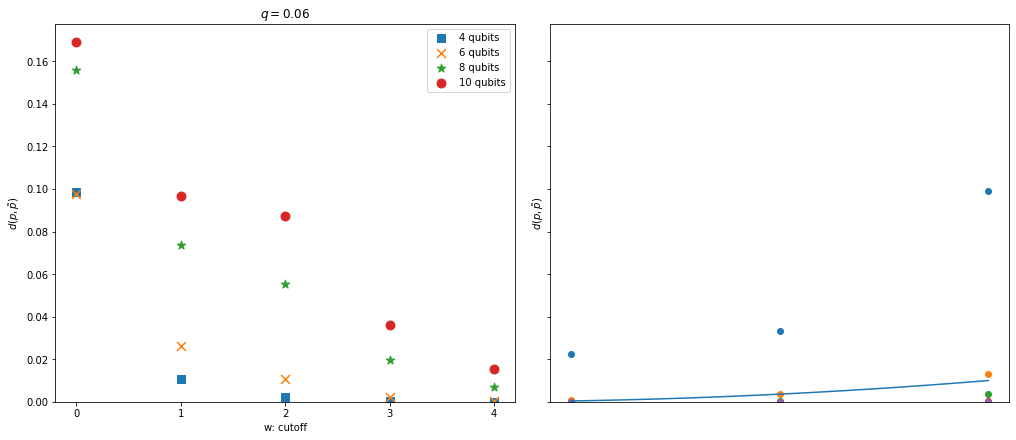

In [39]:
all_outcomes = np.vstack((baseline, outcomes))
q_all_outcomes = np.vstack((q_baseline, q_outcomes))

x = [0] + wvals

leglabs = [f"{x} qubits" for x in nqubits_lst]
markers = [',', 'x', '*', 'o', '*']

fig, axes = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True, sharey=True)

# Full distr results
for j, y in enumerate(all_outcomes.T):
    axes[0].scatter(x, y, label=leglabs[j], marker=markers[j], s=80)
    
for ax in axes:
    ax.set_xticks(x)
    ax.set_xticklabels(x)
    ax.set_ylim(0, ax.get_ylim()[1])
    ax.set_ylabel(r"$d(p, \tilde{p})$")


axes[0].set_xlabel("w: cutoff")
axes[0].set_title(r"$q=${}".format(qfixed))
axes[0].legend()

axes[1].set_xlabel("")

# Second figure: plot trace distance asfu of characteristic q
for j, y in enumerate(q_all_outcomes):
#     axes[1].scatter(qvals, y, label=leglabs[j], marker=markers[j], s=80)
    axes[1].scatter(qvals, y)

qxvals = np.linspace(min(qvals), max(qvals), 100)
axes[1].plot(qxvals, (2 * qxvals) ** 2)
# print(q_all_outcomes)
# print(len(qvals))
# axes[1].scatter(, )


fig.savefig("figures/figure2.pdf")

# Visualizing distributions

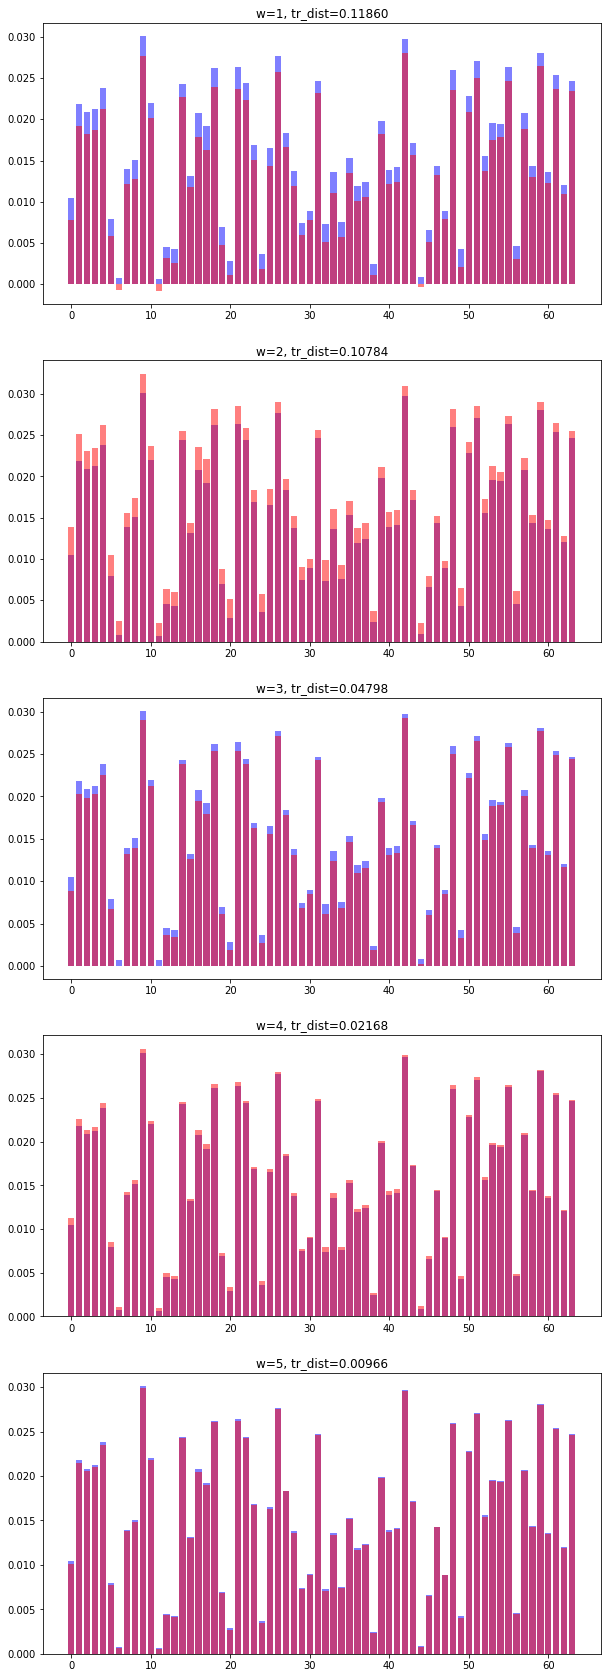

In [11]:
n_qubits = 6
q01_arr = [0.09, .07, 0.12, 0.08, 0.11, 0.06, 0.07, 0.11]
q10_arr = [0.04, .03, .05, 0.04, 0.03, .05, .04, 0.06]
R = response_matrix.Rmatrix(q01_arr[:n_qubits], q10_arr[:n_qubits])
Rinv = np.linalg.inv(R)
p_true = make_random(n_qubits)
p_prime = R @ p_true
x = np.arange(1 << n_qubits)

wvals = [1, 2, 3, 4, 5]

fig, axes = plt.subplots(len(wvals), 1, figsize=(10, 30))
kl_divs = []

for k, w in enumerate(wvals):
    # Empirically i observe that w1,w2 changing independently has little effect on performance
    p_fixed = response_matrix.invert_pfull_truncated(R, p_prime, w1=w, w2=w)
    axes[k].bar(x, p_true, alpha=0.5, label="true distr", color='b')
    axes[k].bar(x, p_fixed, alpha=0.5, label="fixed distr", color='r')
    
    kl_div = trace_dist(p_fixed, p_true)
    axes[k].set_title(f"w={w}, tr_dist={kl_div:3.5f}")
    kl_divs.append(kl_div)
    

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


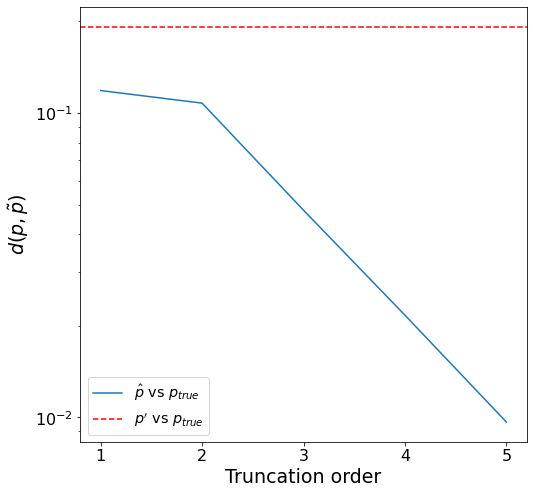

In [12]:
# Plot KL-div as a function of increasing cutoff
plt.style.use('./style.mplstyle')

fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(wvals, kl_divs, label=r"$\hat{p}$ vs $p_{true}$")

# Compare to no error correction
initial_kl = trace_dist(p_prime, p_true)
ax.axhline(initial_kl, ls='--', c='r', label=r"$p'$ vs $p_{true}$")

# ax.set_title("KL_div vs. cutoff w")
ax.semilogy()
ax.set_xlabel(r"Truncation order")
ax.set_ylabel(r"$d(p, \tilde{p})$")
ax.set_xticks(wvals)
ax.legend(prop={'size': 'x-large'})

None

In [13]:
fig.savefig("figure1.pdf")